In [14]:
# All imports in one place for Task 2

import numpy as np          # for arrays and math
import random               # for random choices (exploration in Q-learning)
import matplotlib.pyplot as plt  # for visualizing maze and results
import seaborn as sns       # for nicer heatmaps/plots (optional)
from IPython.display import clear_output  # for refreshing output in training loops


start: (1, 1) goal: (8, 8)


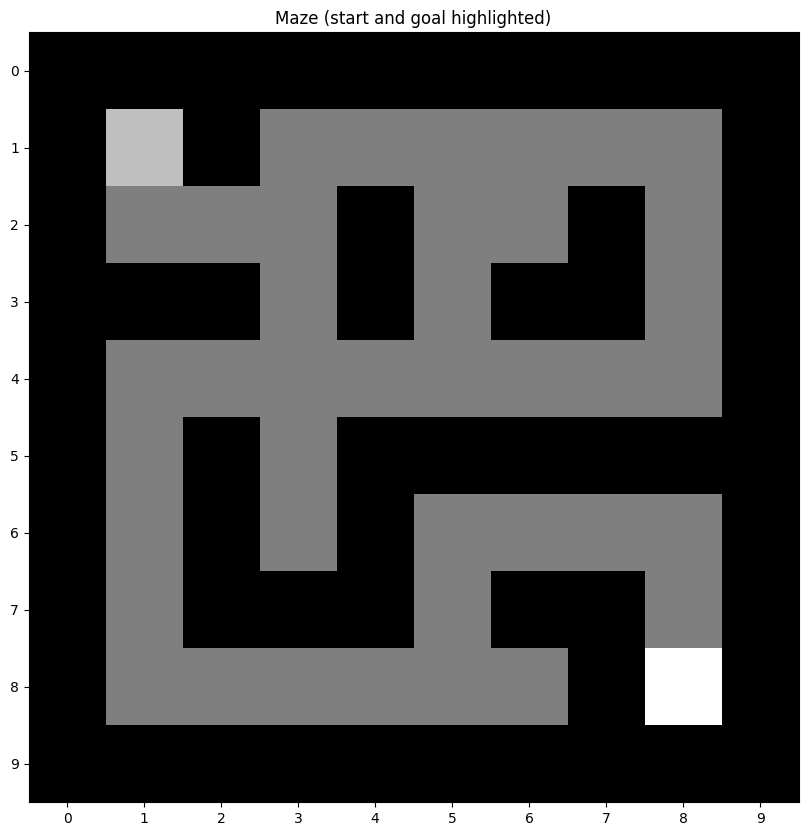

In [15]:
# setting up the maze to match the picture (10x10)
# 0 = free path, 1 = wall
import numpy as np
import matplotlib.pyplot as plt

maze = np.array([
    [1,1,1,1,1,1,1,1,1,1],  # row 0 (outer wall)
    [1,0,1,0,0,0,0,0,0,1],  # row 1 (start area and top corridor)
    [1,0,0,0,1,0,0,1,0,1],
    [1,1,1,0,1,0,1,1,0,1],
    [1,0,0,0,0,0,0,0,0,1],
    [1,0,1,0,1,1,1,1,1,1],
    [1,0,1,0,1,0,0,0,0,1],
    [1,0,1,1,1,0,1,1,0,1],
    [1,0,0,0,0,0,0,1,0,1],  # row 8 (goal corridor)
    [1,1,1,1,1,1,1,1,1,1],  # row 9 (outer wall)
], dtype=np.int8)

# setting start and goal to where they are in the picture
start = (1, 1)   # near "START"
goal  = (8, 8)   # near "GOAL"

print("start:", start, "goal:", goal)

# marking start and goal to be able to see them
vis = maze.astype(float).copy()
vis[start] = -0.5
vis[goal]  = -1.0

# Checking the maze: walls darker, paths lighter, start/goal distinct
plt.figure(figsize=(10,10))
plt.imshow(vis, cmap='gray_r')
plt.title("Maze (start and goal highlighted)")
plt.xticks(range(maze.shape[1]))
plt.yticks(range(maze.shape[0]))
plt.show()



In [16]:
# defining possible actions: up, down, left, right
actions = {
    0: (-1, 0),  # up
    1: (1, 0),   # down
    2: (0, -1),  # left
    3: (0, 1)    # right
}

# setting rewards
# +10 for reaching goal
# -5 for hitting a wall
# -0.1 for each normal step (to encourage shorter path)
goal_reward = 10
wall_penalty = -5
step_penalty = -0.1

print("actions:", actions)
print("rewards -> goal:", goal_reward, " wall:", wall_penalty, " step:", step_penalty)


actions: {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
rewards -> goal: 10  wall: -5  step: -0.1


In [17]:
# Setting up a Q-table with one row per grid cell and one column per action.
# shape is (rows*cols, 4). Starting everything at zero.
rows, cols = maze.shape
n_states = rows * cols
n_actions = 4
Q = np.zeros((n_states, n_actions), dtype=np.float32)

# Writing a tiny helper to convert (row, col) into a single state index.
# Avoiding fancy things: state = row * cols + col
to_state = lambda r, c: r * cols + c

# Fixing the training hyperparameters.
alpha = 0.1      # learning rate: how much adjustment of Q after each step
gamma = 0.95     # discount factor: how much we care about future rewards
epsilon = 1.0    # exploration: start high (more random), will decay later
epsilon_min = 0.05
epsilon_decay = 0.995

# Defining a quick check for which cells are walkable (0 means free).
walkable = (maze == 0)

# Confirming the start and goal states (just printing to be sure).
start_state = to_state(*start)
goal_state  = to_state(*goal)
print("n_states:", n_states, "n_actions:", n_actions)
print("start_state:", start_state, "goal_state:", goal_state)
print("maze is walkable at start?", walkable[start], "and at goal?", walkable[goal])


n_states: 100 n_actions: 4
start_state: 11 goal_state: 88
maze is walkable at start? True and at goal? True


In [18]:
# Training the agent with plain Q-learning.

episodes = 1500         # Giving it enough tries to learn the maze
max_steps = 300         # Don’t want any episode to run forever

returns = []            # Tracking total reward per episode so we can see learning

for ep in range(episodes):
    # Starting each episode at the start cell
    r, c = start
    s = to_state(r, c)
    total_reward = 0.0

    for t in range(max_steps):
        # Choosing an action using ε-greedy
        if random.random() < epsilon:
            a = random.randint(0, n_actions - 1)           # explore
        else:
            a = int(np.argmax(Q[s]))                       # exploit

        # Computing the candidate next cell
        dr, dc = actions[a]
        nr, nc = r + dr, c + dc

        # Checking boundaries first
        out_of_bounds = not (0 <= nr < rows and 0 <= nc < cols)

        # Deciding the immediate reward and the actual next state
        if out_of_bounds or maze[nr, nc] == 1:
            # Treating walls and out-of-bounds the same: penalty and stay put
            reward = wall_penalty
            nr, nc = r, c
        elif (nr, nc) == goal:
            reward = goal_reward
        else:
            reward = step_penalty

        ns = to_state(nr, nc)

        # Updating the Q-value using the standard Q-learning rule
        best_next = np.max(Q[ns])
        Q[s, a] = Q[s, a] + alpha * (reward + gamma * best_next - Q[s, a])

        # Moving to the next state
        r, c = nr, nc
        s = ns
        total_reward += reward

        # Stopping the episode if goal is reached
        if (r, c) == goal:
            break

    # Decaying epsilon a little after each episode (but keeping a small floor)
    if epsilon > epsilon_min:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    returns.append(total_reward)

    # Printing a light heartbeat so we know it’s training
    if (ep + 1) % 300 == 0:
        print(f"episode {ep+1}/{episodes}  epsilon={epsilon:.3f}  last_return={total_reward:.1f}")


episode 300/1500  epsilon=0.222  last_return=-12.5
episode 600/1500  epsilon=0.050  last_return=7.9
episode 900/1500  epsilon=0.050  last_return=7.9
episode 1200/1500  epsilon=0.050  last_return=2.9
episode 1500/1500  epsilon=0.050  last_return=2.9


reached goal? True steps: 22


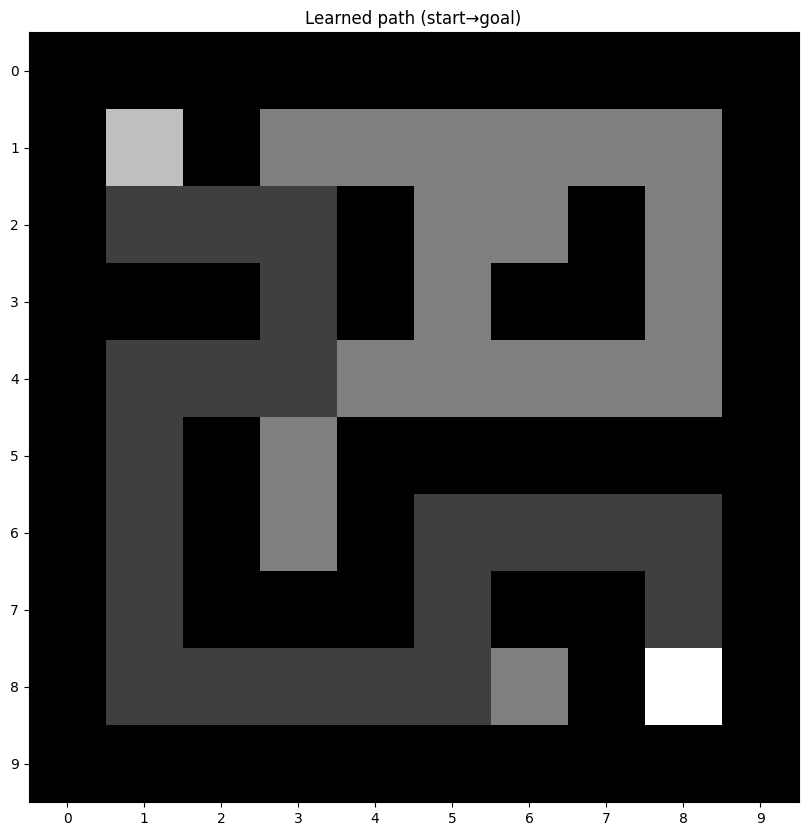

path: [(1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (7, 5), (6, 5), (6, 6), (6, 7), (6, 8), (7, 8), (8, 8)]


In [19]:
# Using the learned Q-table to walk greedily from start to goal.
# Recording the cells to visualize the final path.

path = []
r, c = start
steps_limit = 300  # Keeping a safety cap in case of loops

for _ in range(steps_limit):
    path.append((r, c))
    if (r, c) == goal:
        break

    s = r * cols + c
    a = int(np.argmax(Q[s]))         # Choosing the best action from Q
    dr, dc = actions[a]
    nr, nc = r + dr, c + dc

    # if the best action tries to go into a wall or outside, staying put to avoid crashing
    if not (0 <= nr < rows and 0 <= nc < cols) or maze[nr, nc] == 1:
        # in case it gets stuck, trying a tiny nudge: pick the next-best action
        sort_idx = np.argsort(Q[s])[::-1]  # actions sorted by Q high→low
        moved = False
        for a2 in sort_idx:
            dr2, dc2 = actions[int(a2)]
            rr, cc = r + dr2, c + dc2
            if 0 <= rr < rows and 0 <= cc < cols and maze[rr, cc] == 0:
                r, c = rr, cc
                moved = True
                break
        if not moved:
            # Stop if cannot move
            break
    else:
        r, c = nr, nc

print("reached goal?", path[-1] == goal, "steps:", len(path)-1)

# Drawing the path on top of the maze so we can see where it went.
vis = maze.astype(float).copy()
for (pr, pc) in path:
    vis[pr, pc] = 0.5                 # path marker (mid-gray)
vis[start] = -0.5                      # start marker darker
vis[goal]  = -1.0                      # goal marker darkest

plt.figure(figsize=(10,10))
plt.imshow(vis, cmap='gray_r')
plt.title("Learned path (start→goal)")
plt.xticks(range(cols))
plt.yticks(range(rows))
plt.show()

# Printing the path coordinates.
print("path:", path)


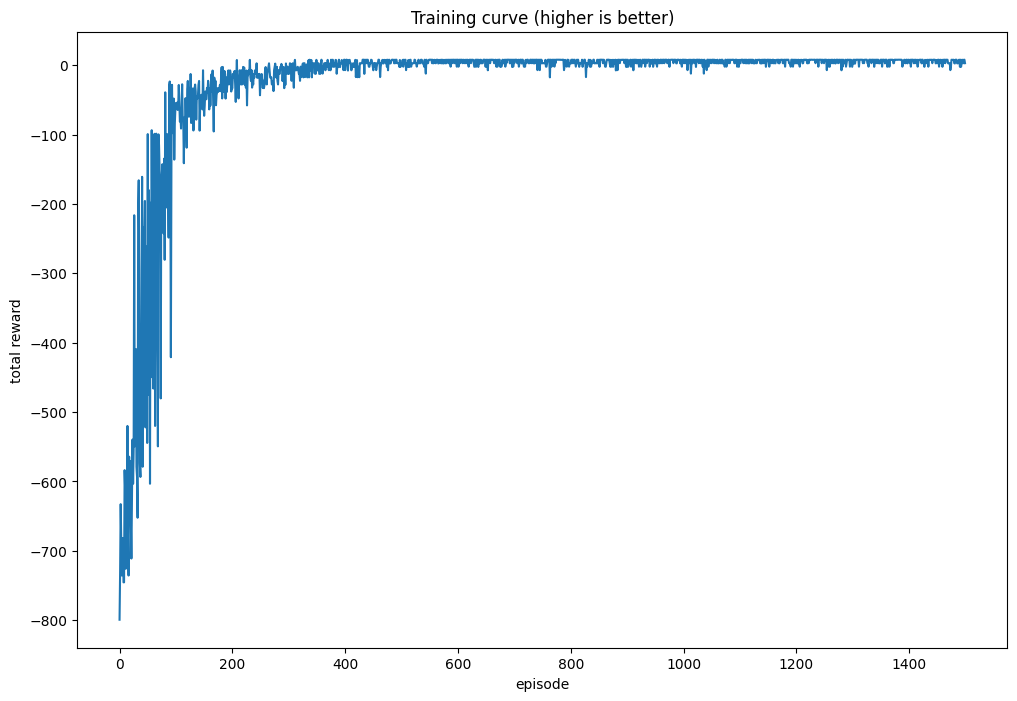

In [20]:
# Plotting total reward per episode.
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(returns)
plt.xlabel("episode")
plt.ylabel("total reward")
plt.title("Training curve (higher is better)")
plt.show()
